# Real-Time Info Midterm Assignment
## Group members: Purva Kapshikar, Hamzah Yaacob, and Jackson Zeng

## Research question
Which bus line among the AC Transit 19, 20, and 51A would benefit most from real-time information displays at some of their bus stops?

## Background

Real-time information displays inform transit riders about when the next bus is arriving at their stop. These displays provide convenience for all transit riders, but they are especially useful for those who lack smartphones or access to the Internet and are therefore unable to access bus arrival times by any other means, especially the elderly (Shrestha et al. 2017). Real-time information at bus stops provide the most benefit for stops serviced by routes that have more unreliable schedules and infrequent headways as riders at these stops likely have longer or more unpredictable wait times. Installing real-time information can also enhance ridership on a given route. A New York City study found that real-time information has also been associated with increases in ridership especially on long and heavily-used routes (Brakewood et al. 2015). 

In this project we will analyze 3 bus routes operated by AC Transit: 19, 20 and 51A. These routes run through the cities of Oakland and Alameda, California. These routes also serve multiple heavy rail (Bay Area Rapid Transit) stations, operate through Downtown Oakland and serve neighborhoods of differing profiles. They also operate at various frequencies with the 51A being the most frequent (every 10-15 minutes) and the 19 being the least frequent (every 30 minutes or more), thereby making it a more representative sample of bus routes operated by AC Transit. In the following analysis we look at demographic data along census tracts near bus stops as well as delay information for each route.

References:

Brakewood, C., Macfarlane, G.S. & Watkins, K. (2015). The Impact of Real-time Information on Bus Ridership in New York City. Transportation Research Part C: Emerging Technologies, 53, 59-75.

Shrestha, B.P., Millonig, A., Hounsell, N.B. & McDonald, M. (2017). Review of Public Transport Needs of Older People in European Context. Journal of Population Ageing, 10, 343-361.

## Data sources

* US Census and ACS estimates: https://data.census.gov/
* AC Transit's Data API & Resource Center: https://www.actransit.org/data-api-resource-center
* MTC 511 Open Data (real-time delays): https://511.org/open-data/transit
* AC Transit on-time performance data

In [131]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import contextily as cx
import plotly.express as px
import folium

## Map of bus lines

We begin with showing the three bus lines (AC Transit 19, 20, and 51A) that we analyze in this project in the context of Oakland and Alameda.

In [132]:
bus_routes = gpd.read_file("data/bus-routes/filtered_bus_routes.shp")

The CRS of the bus routes shapefile is 4326, so we explicitly made it a geodataframe with that reference system.

In [133]:
bus_routes = gpd.GeoDataFrame(bus_routes, 
                      geometry="geometry", 
                      crs="EPSG:4326")

We then convert it to match the CRS of the `contextily` basemap.

In [134]:
bus_routes_wm = bus_routes.to_crs(epsg=3857)

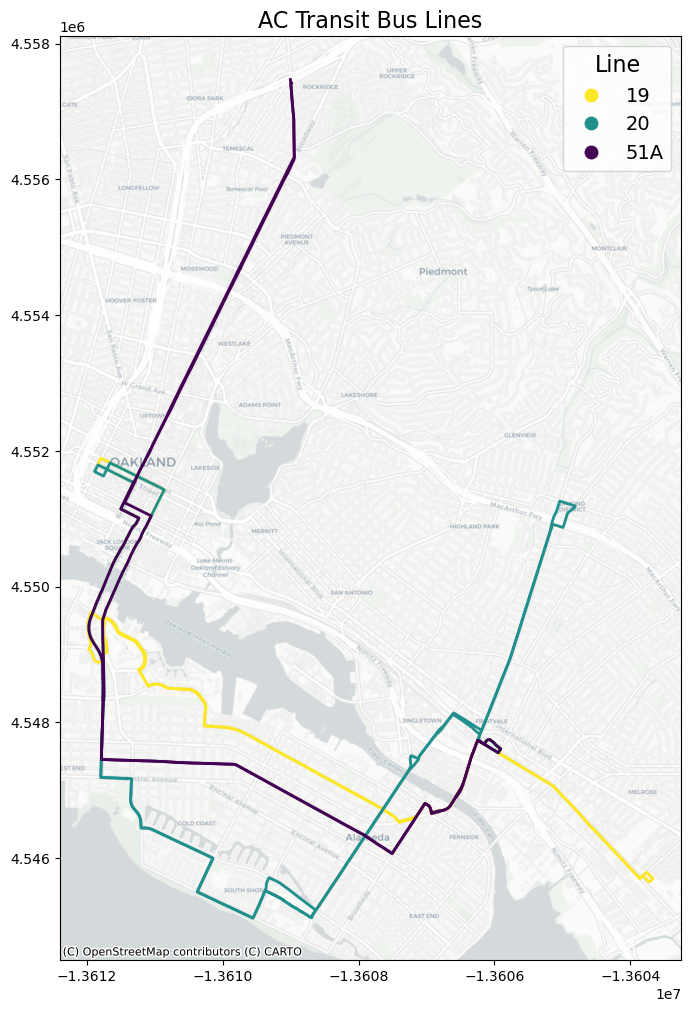

In [135]:
ax_br = bus_routes_wm.plot(column="PUB_RTE", legend=True, figsize=(10,12), linewidth=2, cmap="viridis_r",
                          legend_kwds={
                              'loc': 'upper right',
                              'bbox_to_anchor':(1,1),
                              'title': 'Line',
                              'title_fontsize': 16,
                              'fontsize': 14
                         })
cx.add_basemap(ax_br, source=cx.providers.CartoDB.Positron)
plt.title(label="AC Transit Bus Lines",
          fontsize=16,
          color="black");

## Part 1: Analysis of surrounding Census Tracts
We believed that including these variables in our analysis would allow us to understand the demographics of the census tracts that the 19, 20, and 51A lines run along. We specifically decided to create maps pertaining to minorities within these tracts, such as percentage of Black and Asian populations and percentage of low-income households, as these were populations that were more likely to use public transit or depend on transit for their travels. We also mapped out the surrounding tracts by percentage of workers who take public transportation as we perceived this to be a vital trip purpose and one that could benefit from greater travel time predictability in their trip.

To understand the surrounding area, we downloaded Census data on demographics, housing, and transportation characteristics from Social Explorer and used `geopandas`'s `plot` function to make choropleth maps.

In [136]:
census_tracts_data = pd.read_csv("data/census/census_tracts_data.csv")

In [137]:
census_tracts_data = census_tracts_data.dropna(axis=1,how="all")

We first convert the Social Explorer column names to more comprehensible ones.

In [138]:
columns_to_keep = ['Geo_FIPS',
                   'SE_A03001_001',
                   'SE_A03001_002',
                   'SE_A03001_003',
                   'SE_A03001_005',
                   'SE_A01001_011',
                   'SE_A01001_012',
                   'SE_A01001_013',
                   'SE_A14001_001',
                   'SE_A14001_002',
                   'SE_A14001_003',
                   'SE_A14001_004',
                   'SE_A14001_005',
                   'SE_A14001_006',
                   'SE_A14001_007',
                   'SE_A14001_008',
                   'SE_A09005_001',
                   'SE_A09005_003']
census_tracts_data = census_tracts_data[columns_to_keep]

In [139]:
census_tracts_data.columns = ['FIPS',
                              'Total Population',
                              'White Alone',
                              'Black or African American Alone',
                              'Asian Alone',
                              '65 to 74 years',
                              '75 to 84 years',
                              '85 years and above',
                              'Households',
                              'Less than $10,000',
                              '$10,000 to $14,999',
                              '$15,000 to $19,999',
                              '$20,000 to $24,999',
                              '$25,000 to 29,999',
                              '$30,000 to $34,999',
                              '$35,000 to $39,999',
                              'Workers 16 years and over',
                              'Public Transportation (Includes Taxicab)']

In [140]:
geom_census_data = pd.read_csv('data/census/bus_route_tracts.csv')

In [141]:
geom_census_data = geom_census_data.rename(columns = {"GEOID":"FIPS"})
geom_census_data = geom_census_data[["FIPS", "geometry"]]

We have two datasets, one with the Social Explorer data, and one that has the tract geometries. We merge these on the `FIPS` column.

In [142]:
joined_census_data = census_tracts_data.merge(right=geom_census_data, on="FIPS")

As there is now a `geometry` column, we convert this dataframe to a geodataframe.

In [143]:
joined_census_data["geometry"] = gpd.GeoSeries.from_wkt(joined_census_data["geometry"])
joined_census_data = gpd.GeoDataFrame(joined_census_data, geometry="geometry")

We create variables for percent Black, percent Asian, percent low income, and percent taking transit using the Social Explorer data, as we believe this is easier to understand than actual counts through choropleth maps. We also use the `contextily` library for their basemaps -- here we've used CartoDB's Positron basemap. We also modify the `alpha` value so that the tracts are more transparent.

In [144]:
joined_census_data['PCT_Black'] = joined_census_data['Black or African American Alone']/joined_census_data['Total Population']*100

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:944: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



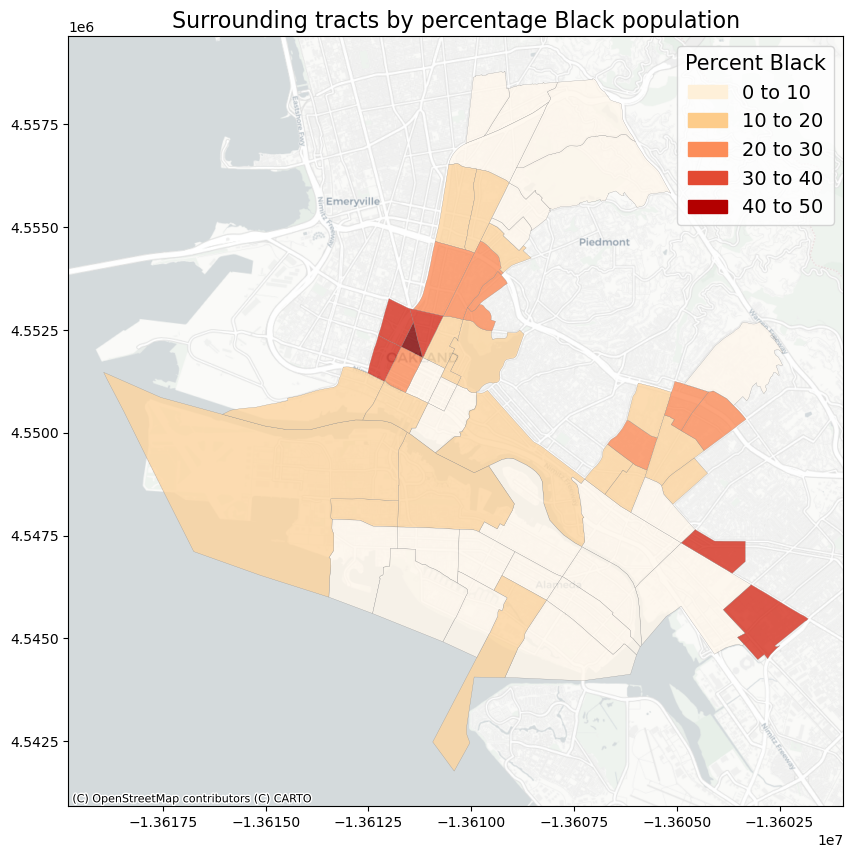

In [145]:
bins_bl = [10, 20, 30, 40, 50]

bl_1 = mpatches.Patch(color='#fef0d9', label='0 to 10') 
bl_2 = mpatches.Patch(color='#fdcc8a', label='10 to 20')
bl_3 = mpatches.Patch(color='#fc8d59', label='20 to 30')
bl_4 = mpatches.Patch(color='#e34a33', label='30 to 40')
bl_5 = mpatches.Patch(color='#b30000', label='40 to 50')

ax_bl = joined_census_data.plot(figsize=(12,10),
                         column='PCT_Black',
                         legend=True,
                         cmap='OrRd',
                         scheme='UserDefined',
                         classification_kwds={'bins': bins_bl},
                         linewidth=0.2,
                         edgecolor='grey',
                         alpha=0.8,
                         legend_kwds={
                              'loc': 'upper right',
                              'bbox_to_anchor':(1,1),
                              'title': 'Percent Black',
                              'title_fontsize': 15,
                              'fontsize': 14,
                              'handles': [bl_1, bl_2, bl_3, bl_4, bl_5]
                         })
cx.add_basemap(ax_bl, source=cx.providers.CartoDB.Positron)
plt.title(label="Surrounding tracts by percentage Black population",
          fontsize=16,
          color="black");

In [146]:
joined_census_data['PCT_Asian'] = joined_census_data['Asian Alone']/joined_census_data['Total Population']*100

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:944: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



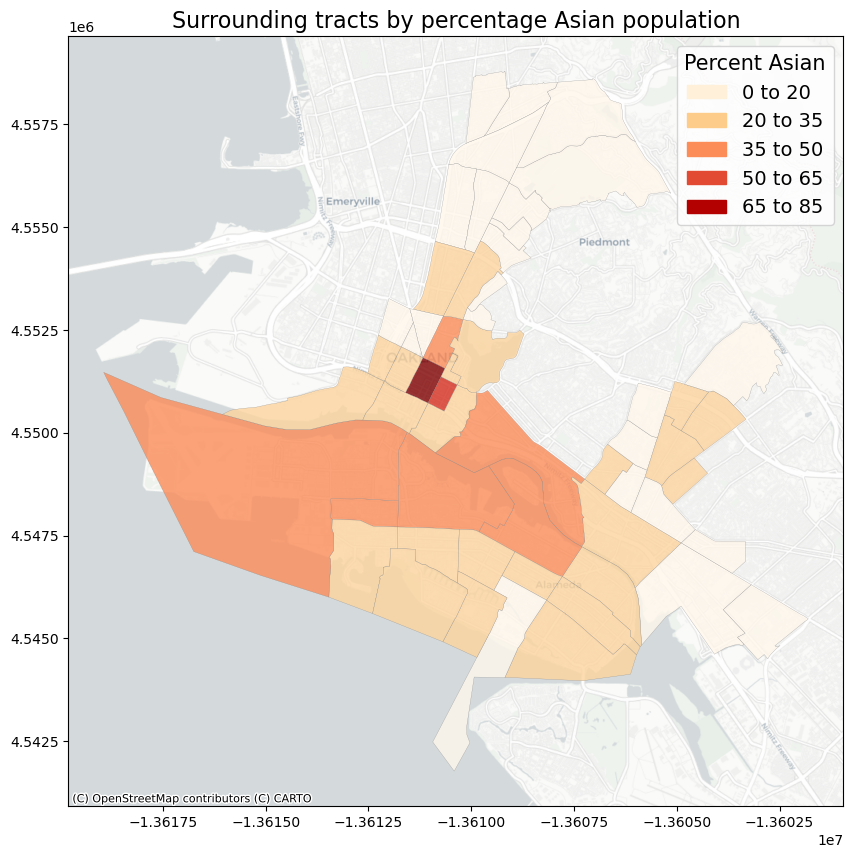

In [147]:
bins_as = [20, 35, 50, 65, 85]

as_1 = mpatches.Patch(color='#fef0d9', label='0 to 20') 
as_2 = mpatches.Patch(color='#fdcc8a', label='20 to 35')
as_3 = mpatches.Patch(color='#fc8d59', label='35 to 50')
as_4 = mpatches.Patch(color='#e34a33', label='50 to 65')
as_5 = mpatches.Patch(color='#b30000', label='65 to 85')


ax_as = joined_census_data.plot(figsize=(12,10),
                         column='PCT_Asian',
                         legend=True,
                         cmap='OrRd',
                         scheme='UserDefined',
                         classification_kwds={'bins': bins_as},
                         linewidth=0.2,
                         edgecolor='grey',
                         alpha=0.8,
                         legend_kwds={
                              'loc': 'upper right',
                              'bbox_to_anchor':(1,1),
                              'title': 'Percent Asian',
                              'title_fontsize': 15,
                              'fontsize': 14,
                              'handles': [as_1, as_2, as_3, as_4, as_5]
                         })
cx.add_basemap(ax_as, source=cx.providers.CartoDB.Positron)
plt.title(label="Surrounding tracts by percentage Asian population",
          fontsize=16,
          color="black");

We considered low-income households as those with incomes less than than $40,000.

In [148]:
joined_census_data['Low_Income'] = joined_census_data['Less than $10,000'] + joined_census_data['$10,000 to $14,999'] +joined_census_data['$15,000 to $19,999'] +  joined_census_data['$20,000 to $24,999'] +  joined_census_data['$25,000 to 29,999'] + joined_census_data['$30,000 to $34,999'] + joined_census_data['$35,000 to $39,999']

In [149]:
joined_census_data['PCT_Low_Income'] = joined_census_data['Low_Income']/joined_census_data['Households']*100

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:944: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



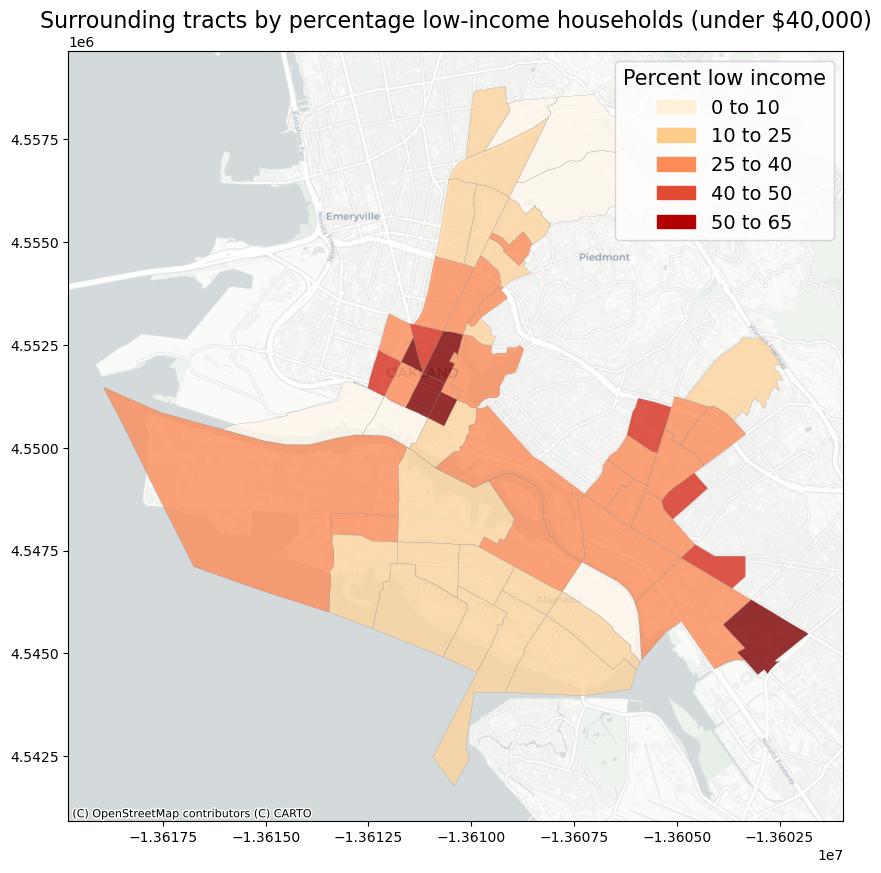

In [150]:
bins_li = [10, 25, 40, 50, 65]

li_1 = mpatches.Patch(color='#fef0d9', label='0 to 10') 
li_2 = mpatches.Patch(color='#fdcc8a', label='10 to 25')
li_3 = mpatches.Patch(color='#fc8d59', label='25 to 40')
li_4 = mpatches.Patch(color='#e34a33', label='40 to 50')
li_5 = mpatches.Patch(color='#b30000', label='50 to 65')

ax_li = joined_census_data.plot(figsize=(12,10),
                         column='PCT_Low_Income',
                         legend=True,
                         cmap='OrRd',
                         scheme='UserDefined',
                         classification_kwds={'bins': bins_li},
                         linewidth=0.2,
                         edgecolor='grey',
                         alpha=0.8,
                         legend_kwds={
                              'loc': 'upper right',
                              'bbox_to_anchor':(1,1),
                              'title': 'Percent low income',
                              'title_fontsize': 15,
                              'fontsize': 14,
                              'handles': [li_1, li_2, li_3, li_4, li_5]
                         })
cx.add_basemap(ax_li, source=cx.providers.CartoDB.Positron)
plt.title(label="Surrounding tracts by percentage low-income households (under $40,000)",
          fontsize=16,
          color="black");

In [151]:
joined_census_data['PCT_Take_Transit'] = joined_census_data['Public Transportation (Includes Taxicab)']/joined_census_data['Workers 16 years and over']*100

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:944: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



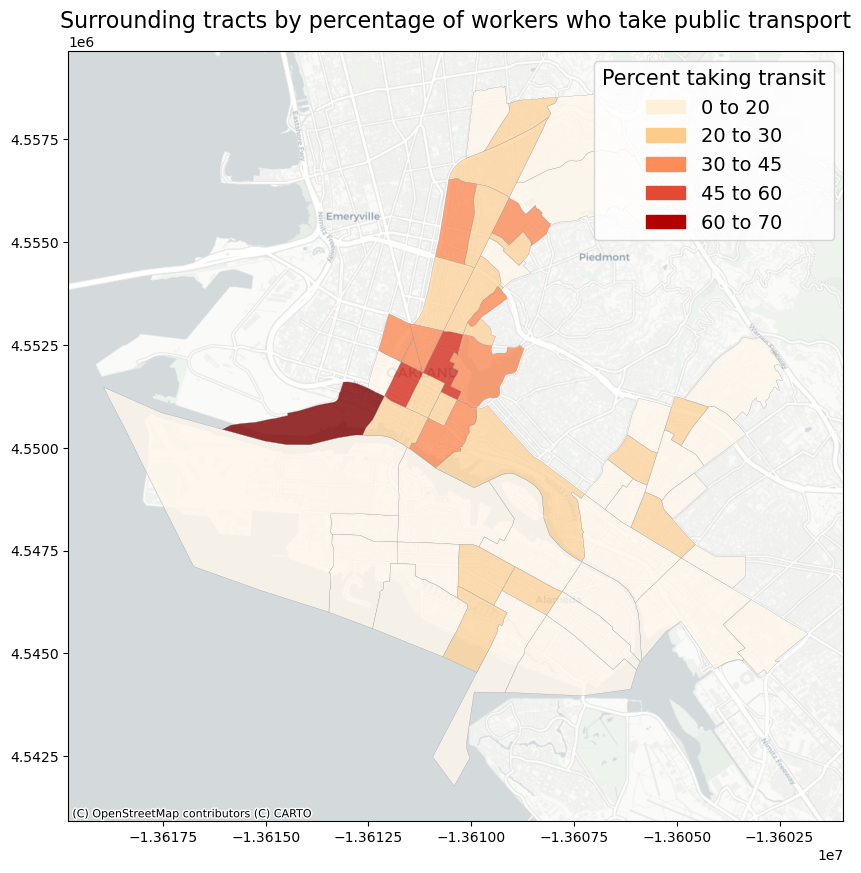

In [152]:
bins_tr = [20, 30, 45, 60, 70]

tr_1 = mpatches.Patch(color='#fef0d9', label='0 to 20') 
tr_2 = mpatches.Patch(color='#fdcc8a', label='20 to 30')
tr_3 = mpatches.Patch(color='#fc8d59', label='30 to 45')
tr_4 = mpatches.Patch(color='#e34a33', label='45 to 60')
tr_5 = mpatches.Patch(color='#b30000', label='60 to 70')

ax_tr = joined_census_data.plot(figsize=(12,10),
                         column='PCT_Take_Transit',
                         legend=True,
                         cmap='OrRd',
                         scheme='UserDefined',
                         classification_kwds={'bins': bins_tr},
                         linewidth=0.2,
                         edgecolor='grey',
                         alpha=0.8,
                         legend_kwds={
                              'loc': 'upper right',
                              'bbox_to_anchor':(1,1),
                              'title': 'Percent taking transit',
                              'title_fontsize': 15,
                              'fontsize': 14,
                              'handles': [tr_1, tr_2, tr_3, tr_4, tr_5]
                         })
cx.add_basemap(ax_tr, source=cx.providers.CartoDB.Positron)
plt.title(label="Surrounding tracts by percentage of workers who take public transport",
          fontsize=16,
          color="black");

From looking at these maps, the tracts with more low income households and greater transit ridership do seem to be aligned with those tracts that have more people of color.

## Part 2: Highest Transit Ridership Tracts
We were then interested in taking a deeper dive into understanding the travel choices of those within census tracts that had the highest number of public transportation users compared to all other tracts. We started out with a plot of the number of public transportation users in the surrounding tracts with the most number of residents using public transportation. Then, we expanded upon our analysis in a later iteration by looking at the mode share of residents within these tracts that had the highest transit ridership. We find that the tracts that have the highest transit ridership also seem to have higher counts of walking and biking. We recognize that taking transit often involves active transportation for first and last mile access, and we believed that these travelers could benefit from greater reliability to minimize their wait time at the stop. Thus, we also used data provided to us by AC Transit to plot the monthly on-time performance of the three lines in 2022, defined by AC Transit as the percentage of trips that departed up to five minutes late. 

Given that there seemed to be some tracts with significantly high transit ridership, we were particularly interested in the mode share of households in the area, and so we determined the five tracts that had the most transit ridership along each bus line. In this file, we show these for the 51A line. We first load the Census data and the dataset containing the geometries and join the two together.

In [153]:
census_data_51a = pd.read_csv("data/51a-tract-data/tracts_data_51a.csv")
geom_data_51a = pd.read_csv("data/51a-tract-data/tracts_51A.csv")
geom_data_51a = geom_data_51a.rename(columns={"GEOID": "FIPS"})
geom_data_51a = geom_data_51a.loc[:, ["FIPS", "geometry"]]
data_51a = census_data_51a.merge(right=geom_data_51a, on="FIPS")

We then make this dataframe a geodataframe.

In [154]:
data_51a["geometry"] = gpd.GeoSeries.from_wkt(data_51a["geometry"])
data_51a = gpd.GeoDataFrame(data_51a, geometry="geometry")

We updated the headers of these columns as they were very long.

In [155]:
modes = ["Drove Alone", "Carpooled", "Public Transportation (Includes Taxicab)", "Motorcycle", "Bicycle", "Walked", "Other Means"]

for i in range(7):
    data_51a = data_51a.rename(columns={"Workers 16 Years and Over: " + modes[i]: modes[i]})

We first determine these top five tracts.

In [156]:
top_5_transit_tracts = data_51a.sort_values(by="Public Transportation (Includes Taxicab)", ascending = False).head(5)

We first plot the count of residents using public transit using `pandas`'s `bar.h` function.

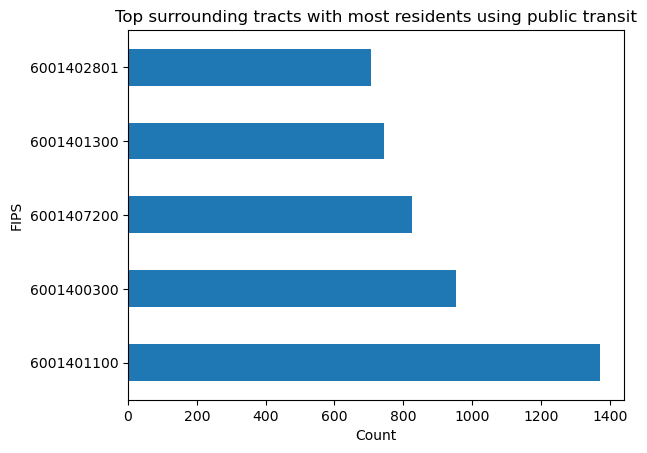

In [157]:
top_5_transit_tracts.plot.barh(x="FIPS",
                            y="Public Transportation (Includes Taxicab)",
                            xlabel="Count",
                            title="Top surrounding tracts with most residents using public transit",
                            legend=False);

As we learned about the `plotly` library the following week, we improved upon the chart by making an interactive bar chart that also showed the overall mode share of these tracts, with the interactivity allowing a viewer to see the specific counts for each mode. We converted our dataframe to be in a "long" dataframe format to work with `plotly`'s `bar` function.

In [158]:
top_5_transit_tracts['Area Name'] = top_5_transit_tracts['Area Name'].str.replace("Census Tract ", "")

In [159]:
top_5_transit_tracts_long = pd.melt(top_5_transit_tracts, id_vars='Area Name', value_vars=modes)

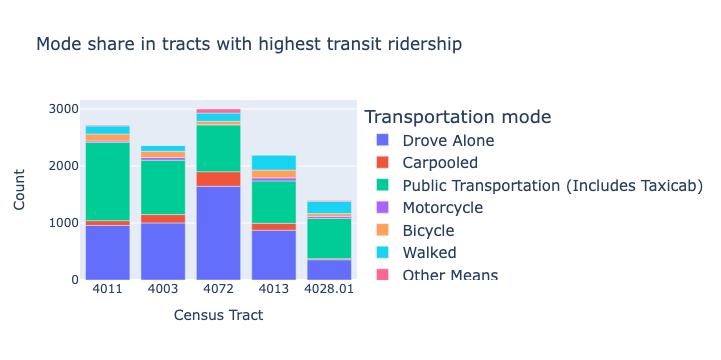

In [160]:
fig_transit_tracts = px.bar(top_5_transit_tracts_long, x="Area Name", y="value", color="variable", 
                            labels={
                                "value": "Count",
                                "variable": "Transportation mode",
                            },
                            title="Mode share in tracts with highest transit ridership")

fig_transit_tracts.update_layout(xaxis_title="Census Tract", legend=dict(font=dict(size=15)))
fig_transit_tracts.show()

We find that the tracts that have the highest transit ridership also seem to have higher counts of walking and biking. We recognize that taking transit often involves active transportation for first and last mile access, .

We reached out to AC Transit for data on delays and performance. They shared with us data on on-time performance for these three lines, which we have ploted below.

In [161]:
otp_19 = pd.read_csv('data/on-time performance/On Time Performance_Line 19 (2022).csv')
otp_20 = pd.read_csv('data/on-time performance/On Time Performance_Line 20 (2022).csv')
otp_51A = pd.read_csv('data/on-time performance/On Time Performance_Line 51A (2022).csv')

In [162]:
def plot_otp(df, i, line):
    df.iloc[:,1] = df.iloc[:,1]*100
    df.iloc[:,2] = df.iloc[:,2]*100
    
    f = df.plot(ax=axes_otp[i], rot=90, legend=False, figsize=(11,5))
    f.set_ylim(ymin=0, ymax=100)

    if i == 0:
        f.set_ylabel("Percent")
    else:
        f.set_yticks([])
        
    f.set_xticks(np.linspace(0,11,12), labels=["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"])
    f.set_title("Line " + line)
    
    if i == 2:
        line_blue = Line2D([0], [0], label='Towards Uptown Oakland', color='#1f77b4')
        line_orange = Line2D([0], [0], label='Towards East Oakland', color='#ff7f0e')
        f.legend(loc = 'lower right', handles=[line_blue, line_orange])
        

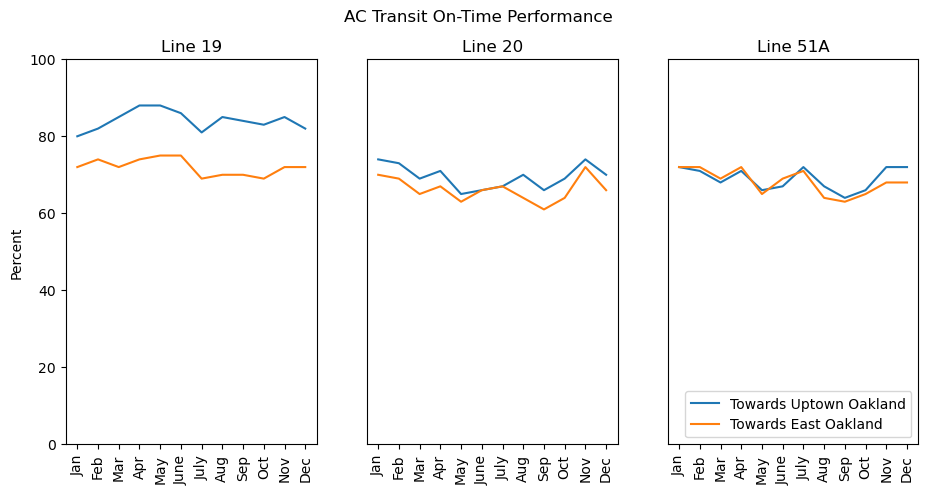

In [163]:
fig_otp, axes_otp = plt.subplots(nrows=1, ncols=3)
plot_otp(otp_19, 0, "19")
plot_otp(otp_20, 1, "20")
plot_otp(otp_51A, 2, "51A")
fig_otp.suptitle("AC Transit On-Time Performance");

## Part 3: Real-time delays

Finally, we decided to map out the bus stops within each of the three lines with average delays that exceeded AC Transit’s on-time performance threshold of five minutes. We hoped to create these maps to help us decide which stops within the most unreliable line would benefit from real-time information displays.  

We collected real-time transit data via Open 511 SIRI APIs. This data is provided in an XML format and has information such as bus expected and aimed arrival and departure times. To determine which stops have the greatest average delays, we are gathering this real-time delay data during different times of day (peak and off-peak, AM and PM) throughout the week. The following interactive maps show bus stops with average delays over five minutes, during Sunday afternoons.

In [164]:
stops_shp_file = gpd.read_file('data/bus-stops/UniqueStops_Fall22.shp')
stops_shp_file.to_file('data/bus-stops/UniqueStops_Fall22.shp', driver='GeoJSON')

We had shapefiles with data on all bus stops from AC Transit's Data and Resource Center, and we had previously filtered these by line for the three bus lines we consider.

In [165]:
delays_19 = pd.read_csv('data/real-time delays/Line 19.csv')
delays_20 = pd.read_csv('data/real-time delays/Line 20.csv')
delays_51A = pd.read_csv('data/real-time delays/Line 51A.csv')

We join these bus stops associated with each line to the shapefile that has a `geometry` column for us to plot.

In [166]:
joined_geom_data_19 = delays_19.merge(stops_shp_file, left_on='stop_code', right_on='stp_511_id', how = 'left')
joined_geom_data_20 = delays_20.merge(stops_shp_file, left_on='stop_code', right_on='stp_511_id', how = 'left')
joined_geom_data_51A = delays_51A.merge(stops_shp_file, left_on='stop_code', right_on='stp_511_id', how = 'left')

The following function takes in a geodataframe and filters it so that the remaining rows are only those stops that have average delays of greater than five minutes.

In [167]:
def filter_for_delays(geom_data):
    geom_data = geom_data[geom_data.iloc[:,5] > 300]
    geom_data.columns.values[5] = "Average Delay"
    geom_data['lon'] = geom_data.geometry.apply(lambda p: p.x)
    geom_data['lat'] = geom_data.geometry.apply(lambda p: p.y)
    
    return geom_data

The following function takes in a geodataframe and plots the filtered stops.

In [168]:
def generate_map(geom_data, line):
    filtered_geom_data = filter_for_delays(geom_data)
    fig = px.scatter_mapbox(filtered_geom_data,
                    lat='lat',
                    lon='lon',
                    zoom=12,
                    hover_name='stop_name',
                    hover_data=["Average Delay"],
                    mapbox_style="carto-positron")
    # options on the layout
    fig.update_layout(
        width = 800,
        height = 800,
        title_x=0.5,
        title='Stops with average delays over 5 minutes for AC Transit Line ' + line
    )
    return fig

In [169]:
map_51A = generate_map(joined_geom_data_51A, "51A")
map_51A

/tmp/ipykernel_3240/2253539602.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3240/2253539602.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



As we can see from the maps above, line 20 has the most delays. Line 19 is not even shown as it has no significant average delay. This is interesting as the 20 actually does not run as frequently as the 51A or as infrequently as the 19. However, this might make it more burdensome for riders waiting for the 20 at bus stops, as riders cannot expect the regularity of the 51A and may be waiting at the stop for longer periods of time than expected. We found it impressive that the 19 had no significant delay during our analysis period, but this suggests that the stops along that line may not particularly benefit from real-time information. 

### Recommendations and next steps

We will be looking at AC Transit’s bus stop shelter guide to understand criteria that the agency uses to make determinations about where to install bus shelters. We believe that these stops could potentially be good candidates for installing real time information displays as they may already have the necessary infrastructure in place, such as electrical wiring and sufficient sidewalk space. However, we hope to reach our own conclusions from our analysis that may confirm or refute AC Transit’s recommendations. We also will be performing additional analysis using ridership data obtained from AC Transit to further support our conclusions of which stops could benefit from the installation of real-time information displays. Finally, we will be collecting more real-time data from the 511 API for a variety of times of day and days of the week to better understand patterns of delays.

## Division of work

In this file, the visuals were made by:
* Bus routes map: Purva
* 4 census data maps: data collected and plotted by Hamzah, basemap added by Purva, custom legends added by Purva
* "Bad" transit counts bar graph: Purva
* "Fixed" interactive mode share bar graph: plotted by Purva, edited by Jackson
* AC Transit on-time performance: plotted by Jackson, edited by Purva, custom legend added by Purva
* 2 interactive average delay maps: data collected by Purva, plotted by Jackson

All three members collected and used Census data for this assigment as well as previous assignments. Jackson additionally worked with on-time performance data provided by AC Transit and the average bus delays that Purva calculated. Purva collected real-time data by calling the 511 API, parsing through the XML response, and calculating the average delays.

Hamzah updated the project proposal and wrote the "Background" section above. Jackson wrote the section headings/descriptions for the three parts in our analysis, and updated this for Group Assignment 3 by providing greater context and analysis on our visualizations. Purva compiled and documented all the code in this file.